In [1]:
# ============================================================================
# CELL 1: ENVIRONMENT SETUP
# ============================================================================
import os
print("☢️ CLEANING UP & INSTALLING COMPATIBLE LIBRARIES...")

# 1. Uninstall conflicting libraries
!pip uninstall -y numpy scikit-learn albumentations opencv-python-headless qudida

# 2. Reinstall with strict, compatible versions
# This combination fixes the 'numpy.dtype' error
!pip install "numpy==1.26.4" -q
!pip install "scikit-learn==1.3.2" -q
!pip install "albumentations==1.3.1" "qudida>=0.0.4" "opencv-python-headless<4.9" -q

# 3. Install core ML libraries
!pip install "transformers==4.42.0" "peft==0.11.0" "tokenizers>=0.19.1" -U -q

# 4. Install specific protobuf to fix 'MessageFactory' error
!pip install "protobuf==3.20.3" -U -q

print("\n" + "="*60)
print("✅ ENVIRONMENT SETUP COMPLETE.")
print("="*60)
print("🛑 STOP! YOU MUST RESTART THE RUNTIME NOW.")
print("1. Go to 'Runtime' > 'Restart Session' (or 'Restart Runtime')")
print("2. After restarting, DO NOT run this cell again.")
print("3. Run 'Cell 2: Master Imports' next.")
print("="*60)

☢️ CLEANING UP & INSTALLING COMPATIBLE LIBRARIES...
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: albumentations 2.0.8
Uninstalling albumentations-2.0.8:
  Successfully uninstalled albumentations-2.0.8
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
woodwork 0.31.0 requires scikit-learn>=1.1.0, which is not installed.
boruta

In [2]:
# ============================================================================
# CELL 2: MASTER IMPORTS & VERIFICATION
# ============================================================================
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, roc_curve)
import warnings

# --- Fixes & Suppressions ---
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")

print("✅ All libraries imported successfully.")
print(f"✅ Numpy version: {np.__version__} (Target: 1.26.4)")
print(f"✅ Sklearn version: {sklearn.__version__} (Target: 1.3.2)")
print(f"✅ Torch version: {torch.__version__}")
print(f"✅ Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✅ All libraries imported successfully.
✅ Numpy version: 1.26.4 (Target: 1.26.4)
✅ Sklearn version: 1.3.2 (Target: 1.3.2)
✅ Torch version: 2.6.0+cu124
✅ Device: cuda


In [3]:
# ============================================================================
# CELL 3: CONFIGURATION (FIXED)
# ============================================================================
import os
import torch
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class Config:
    # === PATHS (FIXED) ===
    csv_path: str = "/kaggle/input/siim-isic-melanoma-classification/train.csv"
    img_dir: str = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train"
    output_dir: str = "/kaggle/working/clip_lora_output"
    
    # === MODEL SETTINGS ===
    clip_model_name: str = "openai/clip-vit-base-patch32"
    image_size: int = 224
    
    # === LORA HYPERPARAMETERS ===
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.1
    lora_target_modules: List[str] = None
    
    # === TRAINING SETTINGS ===
    batch_size: int = 32
    num_epochs: int = 10
    learning_rate: float = 5e-5
    weight_decay: float = 0.01
    warmup_steps: int = 100
    max_grad_norm: float = 1.0
    
    # === CLASS IMBALANCE HANDLING (FIXED) ===
    use_focal_loss: bool = False  # <-- FIX: Turn OFF Focal Loss
    focal_alpha: float = 0.25   # <-- This value will now be ignored
    focal_gamma: float = 2.0
    use_class_weights: bool = True   # <-- FIX: Turn ON Weighted BCE Loss
    
    # === DATA SAMPLING ===
    train_val_split: float = 0.15
    use_full_dataset: bool = False
    sample_size: Optional[int] = 2000
    min_malignant_samples: int = 300 # 300 / 2000 = 15% malignant
    
    # === CONTRASTIVE LEARNING ===
    temperature: float = 0.07
    contrastive_weight: float = 0.3
    
    # === AUGMENTATION ===
    use_augmentation: bool = True
    
    # === SYSTEM ===
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2

    def __post_init__(self):
        os.makedirs(self.output_dir, exist_ok=True)
        if self.lora_target_modules is None:
            self.lora_target_modules = ["q_proj", "v_proj"]

config = Config()
print(f"Configuration loaded. Output dir: {config.output_dir}")
print(f"Device: {config.device}")
print(f"✅ Using Weighted BCE Loss: {config.use_class_weights}")
print(f"✅ Using Focal Loss: {config.use_focal_loss}")

Configuration loaded. Output dir: /kaggle/working/clip_lora_output
Device: cuda
✅ Using Weighted BCE Loss: True
✅ Using Focal Loss: False


In [4]:
# ============================================================================
# CELL 4: DATASET CLASS
# ============================================================================
class SkinLesionDataset(Dataset):
    DIAGNOSIS_DESCRIPTIONS = {
        'melanoma': 'malignant melanoma with irregular borders and color variation',
        'nevus': 'benign nevus or mole',
        'seborrheic keratosis': 'benign seborrheic keratosis with waxy appearance',
        'lentigo': 'benign solar lentigo or age spot',
        'dermatofibroma': 'benign dermatofibroma',
        'vascular lesion': 'benign vascular lesion',
        'basal cell carcinoma': 'malignant basal cell carcinoma',
        'squamous cell carcinoma': 'malignant squamous cell carcinoma',
        'actinic keratosis': 'precancerous actinic keratosis'
    }
    
    def __init__(self, df: pd.DataFrame, img_dir: str, processor: CLIPProcessor, augment: bool = False, is_training: bool = True):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.processor = processor
        self.augment = augment and is_training
        self.is_training = is_training
        
        if self.augment:
            self.transform = A.Compose([
                A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
                A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
                A.Rotate(limit=20, p=0.5),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                A.GaussianBlur(blur_limit=(3, 7), p=0.3),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
            ])
        else:
            self.transform = A.Compose([A.Resize(height=224, width=224)])
    
    def __len__(self):
        return len(self.df)
    
    def _find_image_path(self, image_name: str) -> Optional[Path]:
        for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG']:
            img_path = self.img_dir / f"{image_name}{ext}"
            if img_path.exists(): return img_path
        # Fallback for images missing extension in CSV
        img_path_jpg = self.img_dir / f"{image_name}.jpg"
        if img_path_jpg.exists(): return img_path_jpg
        return None
    
    def _get_diagnosis_description(self, diagnosis: str) -> str:
        diagnosis_lower = str(diagnosis).lower().strip()
        for key, desc in self.DIAGNOSIS_DESCRIPTIONS.items():
            if key in diagnosis_lower: return desc
        return ""
    
    def _create_enhanced_text_prompts(self, row: pd.Series) -> Tuple[str, str]:
        site = str(row.get('anatom_site_general_challenge', '')).strip()
        age = row.get('age_approx', None)
        sex = str(row.get('sex', '')).strip().lower()
        diagnosis = str(row.get('diagnosis', '')).strip()
        diagnosis_desc = self._get_diagnosis_description(diagnosis)
        
        if row['target'] == 1:
            base_positive = f"a {diagnosis_desc}" if diagnosis_desc else "a malignant skin lesion with irregular borders and color variation"
            base_negative = "a benign skin lesion with regular features"
        else:
            base_positive = f"a {diagnosis_desc}" if diagnosis_desc else "a benign skin lesion with regular borders"
            base_negative = "a malignant melanoma with irregular features"
        
        metadata_parts = []
        if site and site.lower() not in ['nan', 'none', 'unknown', '']:
            metadata_parts.append(f"located on the {site.replace('_', ' ')}")
        
        if pd.notna(age) and age > 0:
            metadata_parts.append(f"of a {int(age)}-year-old {sex} patient" if sex in ['male', 'female'] else f"of a {int(age)}-year-old patient")
        elif sex in ['male', 'female']:
            metadata_parts.append(f"of a {sex} patient")
        
        suffix = ' '.join(metadata_parts)
        return (f"{base_positive} {suffix}", f"{base_negative} {suffix}") if metadata_parts else (base_positive, base_negative)
    
    def __getitem__(self, idx: int) -> Dict:
        row = self.df.iloc[idx]
        img_path = self._find_image_path(row['image_name'])
        if img_path is None: raise FileNotFoundError(f"Image not found: {row['image_name']} in {self.img_dir}")
        
        image = Image.open(img_path).convert('RGB')
        image_np = np.array(image)
        
        if self.augment:
            image_np = self.transform(image=image_np)['image']
        else:
            image_np = self.transform(image=image_np)['image']
            
        image = Image.fromarray(image_np)
        positive_prompt, negative_prompt = self._create_enhanced_text_prompts(row)
        
        pixel_values = self.processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        
        return {
            'pixel_values': pixel_values,
            'positive_text': positive_prompt,
            'negative_text': negative_prompt,
            'label': torch.tensor(row['target'], dtype=torch.long),
            'image_name': row['image_name']
        }

print("✅ SkinLesionDataset class defined.")

✅ SkinLesionDataset class defined.


In [5]:
# ============================================================================
# CELL 5: DATA PREPARATION
# ============================================================================
def prepare_data(config: Config) -> Tuple[DataLoader, DataLoader, pd.DataFrame, Dict]:
    if not os.path.exists(config.csv_path): 
        raise FileNotFoundError(f"CSV not found: {config.csv_path}")
    
    df = pd.read_csv(config.csv_path)
    print(f"Loaded CSV with {len(df)} total samples.")
    
    # Stratified sampling logic
    if not config.use_full_dataset and config.sample_size:
        malignant_df_all = df[df['target'] == 1]
        benign_df_all = df[df['target'] == 0]
        
        n_malignant = min(len(malignant_df_all), config.min_malignant_samples)
        n_benign = config.sample_size - n_malignant
        
        if n_benign > len(benign_df_all):
            print(f"Warning: Not enough benign samples. Using all {len(benign_df_all)}.")
            n_benign = len(benign_df_all)
            
        malignant_sample = malignant_df_all.sample(n=n_malignant, random_state=42)
        benign_sample = benign_df_all.sample(n=n_benign, random_state=42)
        
        df = pd.concat([malignant_sample, benign_sample], ignore_index=True)
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        print(f"Sampled {len(df)} images ({n_malignant} malignant, {n_benign} benign).")

    # Train/Val split
    train_df, val_df = train_test_split(
        df, 
        test_size=config.train_val_split, 
        stratify=df['target'], 
        random_state=42
    )
    
    # Calculate class weights
    n_pos = (train_df['target'] == 1).sum()
    n_neg = (train_df['target'] == 0).sum()
    pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
    print(f"Train set: {n_pos} positive, {n_neg} negative. Pos_weight for BCE: {pos_weight:.2f}")

    
    class_info = {'n_positive': n_pos, 'n_negative': n_neg, 'pos_weight': pos_weight}
    
    # Initialize Processor
    processor = CLIPProcessor.from_pretrained(config.clip_model_name)
    
    # Create Datasets
    train_dataset = SkinLesionDataset(train_df, config.img_dir, processor, augment=config.use_augmentation, is_training=True)
    val_dataset = SkinLesionDataset(val_df, config.img_dir, processor, augment=False, is_training=False)
    
    # Create Loaders
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, 
        num_workers=config.num_workers, pin_memory=True, drop_last=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False, 
        num_workers=config.num_workers, pin_memory=True
    )
    
    print("✅ DataLoaders ready.")
    return train_loader, val_loader, val_df, class_info

print("✅ prepare_data function defined.")

✅ prepare_data function defined.


In [6]:
# ============================================================================
# CELL 6: MODEL DEFINITION (FIXED)
# ============================================================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets) # alpha for positive, 1-alpha for negative
        focal_loss = alpha_t * focal_weight * ce_loss
        return focal_loss.mean()

class CLIPWithLoRA(nn.Module):
    def __init__(self, config, class_info: Dict):
        super().__init__()
        self.config = config
        
        # 1. Load Base Model
        base_model = CLIPModel.from_pretrained(config.clip_model_name)
        self.tokenizer = CLIPTokenizer.from_pretrained(config.clip_model_name)
        
        # 2. Configure LoRA
        lora_config = LoraConfig(
            r=config.lora_r, 
            lora_alpha=config.lora_alpha, 
            target_modules=config.lora_target_modules, # ["q_proj", "v_proj"]
            lora_dropout=config.lora_dropout, 
            bias="none", 
            task_type=TaskType.FEATURE_EXTRACTION
        )
        
        # 3. Wrap the WHOLE model (Fixes the input_ids error)
        self.clip = get_peft_model(base_model, lora_config)
        
        # 4. Custom Classification Head
        self.classifier = nn.Sequential(
            nn.Dropout(0.3), 
            nn.Linear(base_model.config.projection_dim, 256),
            nn.ReLU(), 
            nn.Dropout(0.2), 
            nn.Linear(256, 1)
        )
        
        # 6. Loss Function (Logic now driven by Config)
        if config.use_focal_loss:
            self.clf_criterion = FocalLoss(alpha=config.focal_alpha, gamma=config.focal_gamma)
            print(f"✅ Using Focal Loss (Alpha: {config.focal_alpha}, Gamma: {config.focal_gamma})")
        elif config.use_class_weights:
            pos_weight_tensor = torch.tensor([class_info['pos_weight']])
            self.clf_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
            print(f"✅ Using Weighted BCE Loss (Pos Weight: {class_info['pos_weight']:.2f})")
        else:
            self.clf_criterion = nn.BCEWithLogitsLoss()
            print("✅ Using Standard BCE Loss")
            
    def forward(self, pixel_values, labels=None, positive_text=None, negative_text=None, return_loss=True):
        # 1. Extract Image Features
        image_embeds = self.clip.get_image_features(pixel_values=pixel_values)
        image_embeds = F.normalize(image_embeds, p=2, dim=-1)
        
        # 2. Classification
        logits = self.classifier(image_embeds).squeeze(-1)
        
        outputs = {'logits': logits, 'image_embeds': image_embeds}
        
        # 3. Loss Computation
        if return_loss and labels is not None:
            clf_loss = self.clf_criterion(logits, labels.float())
            
            if positive_text is not None and negative_text is not None:
                pos_tokens = self.tokenizer(positive_text, padding=True, truncation=True, max_length=77, return_tensors="pt").to(pixel_values.device)
                neg_tokens = self.tokenizer(negative_text, padding=True, truncation=True, max_length=77, return_tensors="pt").to(pixel_values.device)
                
                pos_embeds = F.normalize(self.clip.get_text_features(**pos_tokens), p=2, dim=-1)
                neg_embeds = F.normalize(self.clip.get_text_features(**neg_tokens), p=2, dim=-1)
                
                pos_sim = torch.sum(image_embeds * pos_embeds, dim=-1) / self.config.temperature
                neg_sim = torch.sum(image_embeds * neg_embeds, dim=-1) / self.config.temperature
                
                contrastive_loss = F.cross_entropy(
                    torch.stack([pos_sim, neg_sim], dim=1), 
                    torch.zeros(pixel_values.size(0), dtype=torch.long, device=pixel_values.device)
                )
                
                outputs['contrastive_loss'] = contrastive_loss
                outputs['total_loss'] = clf_loss + self.config.contrastive_weight * contrastive_loss
            else:
                outputs['total_loss'] = clf_loss
                
            outputs['clf_loss'] = clf_loss
            
        return outputs

print("✅ CLIPWithLoRA model defined successfully.")

✅ CLIPWithLoRA model defined successfully.


In [7]:
# ============================================================================
# CELL 7: TRAINER CLASS (FIXED)
# ============================================================================
class Trainer:
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model.to(config.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=config.learning_rate, 
            weight_decay=config.weight_decay
        )
        
        total_steps = len(train_loader) * config.num_epochs
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer, 
            max_lr=config.learning_rate, 
            total_steps=total_steps,
            pct_start=config.warmup_steps / total_steps if total_steps > 0 else 0.0,
            anneal_strategy='cos'
        )
        
        # --- FIX for FutureWarning ---
        self.scaler = torch.amp.GradScaler('cuda')
        
        self.metrics = {
            'train_losses': [], 'val_losses': [], 
            'val_aucs': [], 'val_sensitivities': [], 'val_specificities': []
        }
        self.best_auc = 0.0
        self.best_epoch = 0

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.num_epochs}")
        
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(self.config.device)
            labels = batch['label'].to(self.config.device)
            
            # --- FIX for FutureWarning ---
            with torch.amp.autocast('cuda'):
                outputs = self.model(
                    pixel_values=pixel_values, 
                    labels=labels, 
                    positive_text=batch['positive_text'], 
                    negative_text=batch['negative_text']
                )
                loss = outputs['total_loss']
            
            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.scheduler.step()
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
        return total_loss / len(self.train_loader)

    @torch.no_grad()
    def validate(self, epoch):
        self.model.eval()
        all_preds, all_labels, all_probs = [], [], []
        total_loss = 0
        
        for batch in tqdm(self.val_loader, desc="Validating"):
            pixel_values = batch['pixel_values'].to(self.config.device)
            labels = batch['label'].to(self.config.device)
            
            # --- FIX for FutureWarning ---
            with torch.amp.autocast('cuda'):
                outputs = self.model(
                    pixel_values=pixel_values, 
                    labels=labels, 
                    positive_text=batch['positive_text'], 
                    negative_text=batch['negative_text']
                )
            
            total_loss += outputs['total_loss'].item()
            probs = torch.sigmoid(outputs['logits'])
            
            all_probs.extend(probs.float().cpu().numpy())
            all_preds.extend((probs > 0.5).long().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        # Handle cases with no positive/negative samples in validation batch
        if len(np.unique(all_labels)) < 2:
            auc = 0.0
            print("Warning: Validation set only contains one class. AUC set to 0.0")
        else:
            auc = roc_auc_score(all_labels, all_probs)
        
        cm = confusion_matrix(all_labels, all_preds)
        
        # Robust Sensitivity/Specificity calculation
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        else:
            # Handle edge case where model predicts only one class
            if np.all(np.array(all_preds) == 0): # Predicted all Benign
                specificity = 1.0
                sensitivity = 0.0
            elif np.all(np.array(all_preds) == 1): # Predicted all Malignant
                specificity = 0.0
                sensitivity = 1.0
            else:
                specificity = 0.0
                sensitivity = 0.0

        return {
            'loss': total_loss / len(self.val_loader), 'auc': auc,
            'accuracy': accuracy_score(all_labels, all_preds),
            'sensitivity': sensitivity, 'specificity': specificity,
            'f1': f1_score(all_labels, all_preds, zero_division=0),
            'precision': precision_score(all_labels, all_preds, zero_division=0),
            'recall': sensitivity, # Recall is the same as Sensitivity
            'labels': all_labels, 'predictions': all_preds, 'probabilities': all_probs
        }

    def train(self):
        print(f"Starting training on {self.config.device}...")
        for epoch in range(self.config.num_epochs):
            train_loss = self.train_epoch(epoch)
            val_metrics = self.validate(epoch)
            
            self.metrics['train_losses'].append(train_loss)
            self.metrics['val_losses'].append(val_metrics['loss'])
            self.metrics['val_aucs'].append(val_metrics['auc'])
            self.metrics['val_sensitivities'].append(val_metrics['sensitivity'])
            self.metrics['val_specificities'].append(val_metrics['specificity'])
            
            print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Val AUC: {val_metrics['auc']:.4f} | Sens: {val_metrics['sensitivity']:.4f} | Spec: {val_metrics['specificity']:.4f}")
            
            if val_metrics['auc'] > self.best_auc:
                self.best_auc = val_metrics['auc']
                self.best_epoch = epoch
                torch.save({
                    'model_state_dict': self.model.state_dict(), 
                    'epoch': epoch, 
                    'metrics': val_metrics
                }, Path(self.config.output_dir) / 'checkpoint_best.pt')
                           
        return self.metrics
print("✅ Trainer class defined.")

✅ Trainer class defined.


In [8]:
# ============================================================================
# CELL 8: PLOTTING & ANALYSIS (FIXED)
# ============================================================================
def plot_training_history(history, config):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    if not history['train_losses']:
        print("Warning: No history found to plot.")
        return
        
    epochs = range(1, len(history['train_losses']) + 1)
    
    axes[0, 0].plot(epochs, history['train_losses'], label='Train')
    axes[0, 0].plot(epochs, history['val_losses'], label='Val')
    axes[0, 0].set_title('Losses')
    axes[0, 0].legend()
    
    axes[0, 1].plot(epochs, history['val_aucs'], label='AUC', color='green')
    axes[0, 1].set_title(f'AUC (Best: {max(history["val_aucs"]):.4f})')
    axes[0, 1].legend()

    axes[1, 0].plot(epochs, history['val_sensitivities'], label='Sensitivity')
    axes[1, 0].plot(epochs, history['val_specificities'], label='Specificity')
    axes[1, 0].set_title('Sensitivity vs Specificity')
    axes[1, 0].legend()
    
    axes[1, 1].axis('off')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, predictions, config):
    cm = confusion_matrix(labels, predictions)
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = np.nan_to_num(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix (Normalized)')
    plt.show()

def plot_roc_curve(labels, probabilities, config):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    auc = roc_auc_score(labels, probabilities)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def analyze_predictions(val_df, predictions, probabilities, config):
    df = val_df.copy()
    df['predicted'] = predictions
    df['probability'] = probabilities
    df['correct'] = (df['target'] == df['predicted'])
    df.to_csv(Path(config.output_dir) / 'prediction_analysis.csv', index=False)
    print("Detailed analysis saved.")

print("✅ Plotting functions defined.")

✅ Plotting functions defined.


In [9]:
# ============================================================================
# CELL 9: INFERENCE & SAVING
# ============================================================================
class CLIPInference:
    def __init__(self, model, config):
        self.model = model.eval()
        self.config = config
    
    @torch.no_grad()
    def extract_embeddings(self, dataloader):
        all_embeddings, all_labels, all_names = [], [], []
        for batch in tqdm(dataloader, desc="Extracting Embeddings"):
            pixel_values = batch['pixel_values'].to(self.config.device)
            embeddings = self.model(pixel_values=pixel_values, return_loss=False)['image_embeds'].cpu().numpy()
            all_embeddings.append(embeddings)
            all_labels.extend(batch['label'].numpy())
            all_names.extend(batch['image_name'])
        return {'embeddings': np.vstack(all_embeddings), 'labels': np.array(all_labels), 'image_names': all_names}

def save_model_for_production(model, config):
    torch.save({'model_state_dict': model.state_dict(), 'config': config}, Path(config.output_dir) / 'clip_lora_production.pt')
    
    lora_state = {k: v.cpu() for k, v in model.named_parameters() if 'lora' in k.lower() or 'classifier' in k}
    torch.save(lora_state, Path(config.output_dir) / 'lora_weights.pt')
    print("Model saved for production.")
    
print("✅ Inference & saving functions defined.")

✅ Inference & saving functions defined.


🚀 Starting Training Pipeline...
Loaded CSV with 33126 total samples.
Sampled 2000 images (300 malignant, 1700 benign).
Train set: 255 positive, 1445 negative. Pos_weight for BCE: 5.67


E0000 00:00:1763231268.481453      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763231268.535049      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

✅ DataLoaders ready.


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

✅ Using Weighted BCE Loss (Pos Weight: 5.67)
Starting training on cuda...


Epoch 1/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7917dd735b20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7917dd735b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
<function _MultiProcessingDataLoaderIter.__del__ at 0x7917dd735b20>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/util

Epoch 1 | Loss: 1.3714 | Val AUC: 0.5529 | Sens: 1.0000 | Spec: 0.0000


Epoch 2/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 | Loss: 1.2246 | Val AUC: 0.6782 | Sens: 1.0000 | Spec: 0.0000


Epoch 3/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 | Loss: 1.1764 | Val AUC: 0.7617 | Sens: 0.9333 | Spec: 0.3412


Epoch 4/10:   0%|          | 0/53 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7917dd735b20>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7917dd735b20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 | Loss: 1.1610 | Val AUC: 0.8074 | Sens: 0.8222 | Spec: 0.5725


Epoch 5/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5 | Loss: 1.1051 | Val AUC: 0.8434 | Sens: 0.6444 | Spec: 0.8471


Epoch 6/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6 | Loss: 1.0469 | Val AUC: 0.8439 | Sens: 0.7556 | Spec: 0.7373


Epoch 7/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7917dd735b20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7917dd735b20>Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive(): ^
^ ^^ ^ ^ ^  ^^ ^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^ ^^ ^ 
   File "/usr/lib/

Epoch 7 | Loss: 1.0139 | Val AUC: 0.8456 | Sens: 0.7778 | Spec: 0.7216


Epoch 8/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.9966 | Val AUC: 0.8440 | Sens: 0.7778 | Spec: 0.7137


Epoch 9/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.9754 | Val AUC: 0.8516 | Sens: 0.7111 | Spec: 0.8078


Epoch 10/10:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.9799 | Val AUC: 0.8516 | Sens: 0.7111 | Spec: 0.8118

Loading best model...
Running final validation on best model...


Validating:   0%|          | 0/10 [00:00<?, ?it/s]


✅ FINAL Best AUC: 0.8516


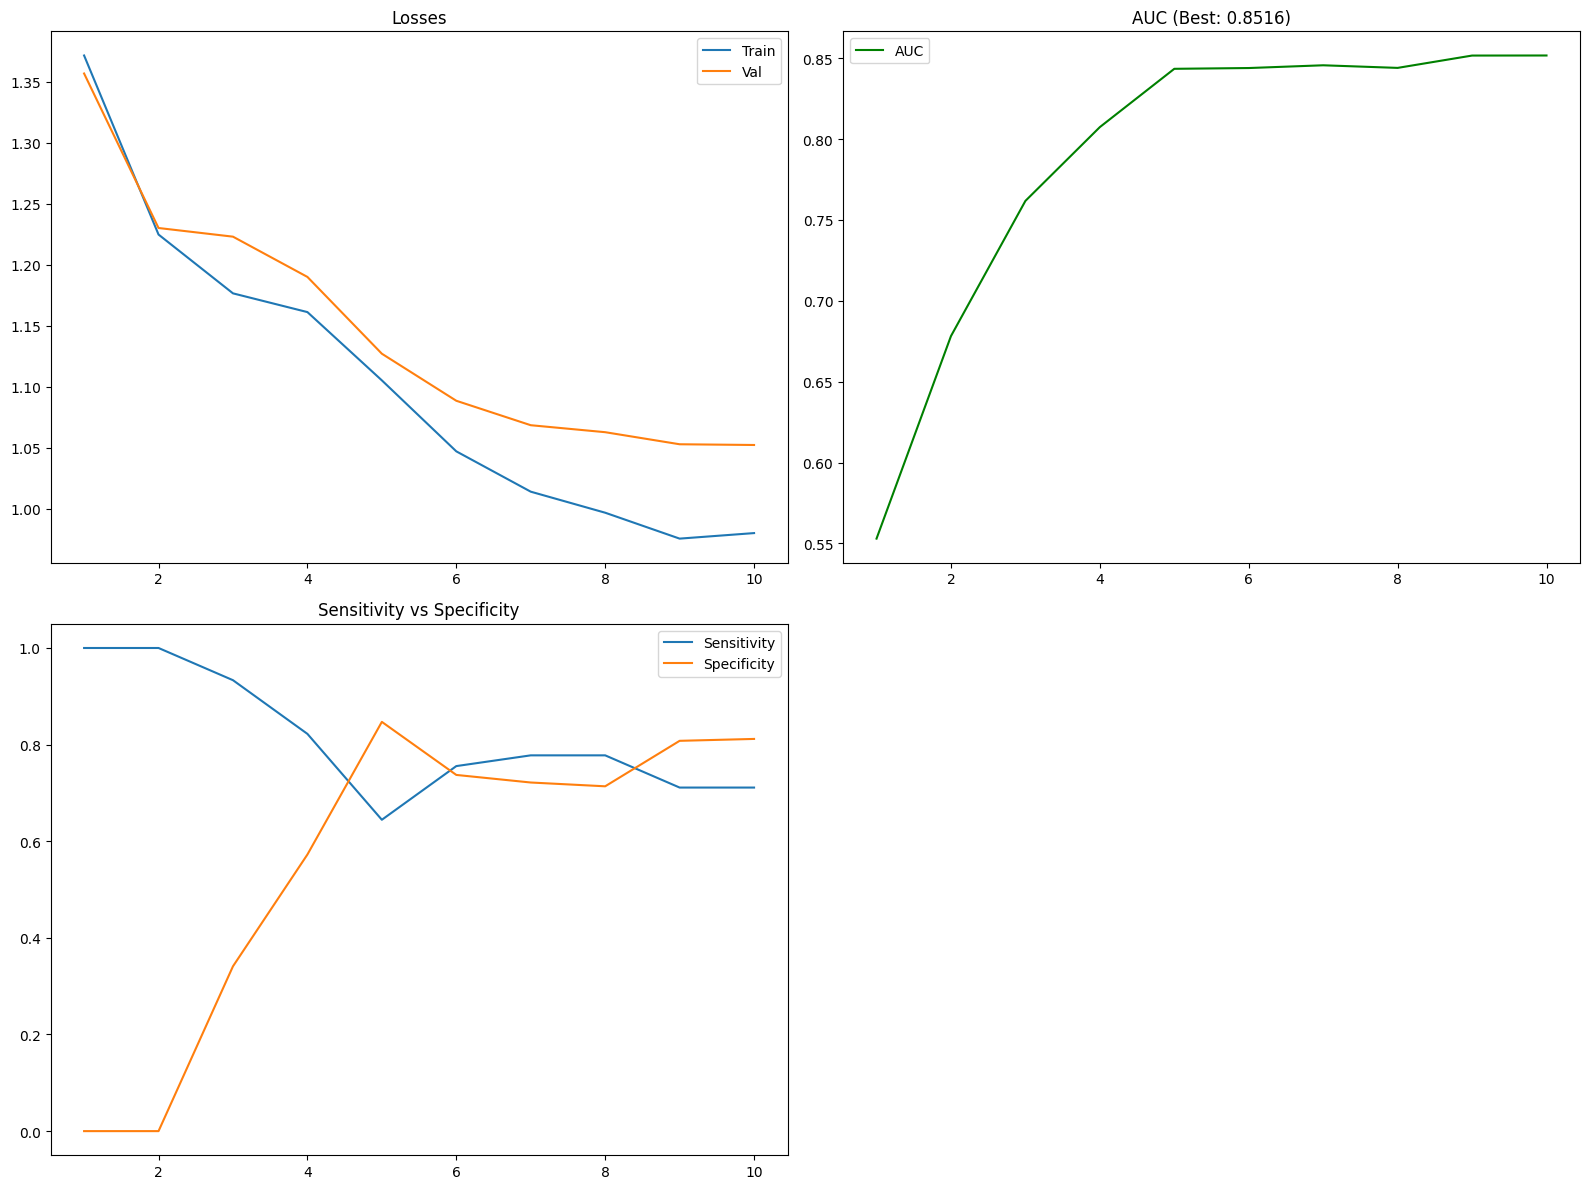

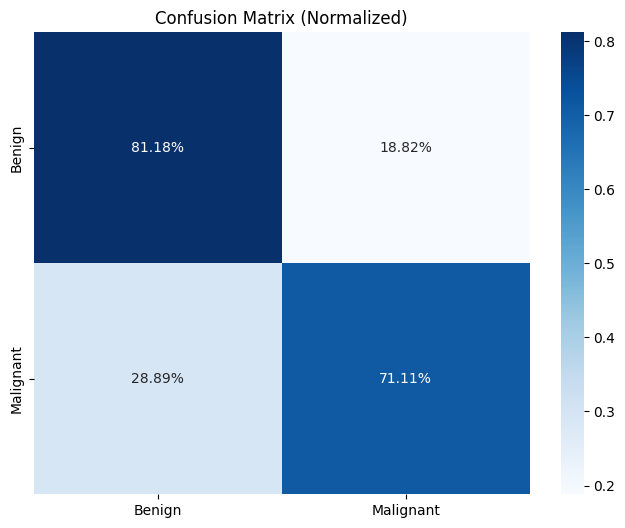

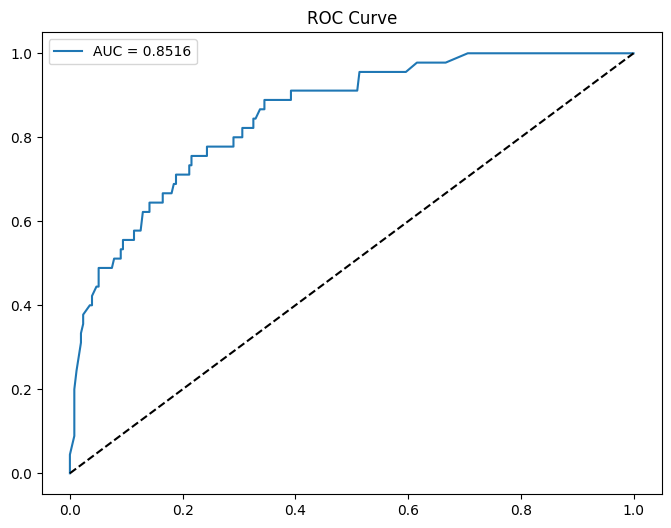

Detailed analysis saved.
Model saved for production.

Extracting embeddings...


Extracting Embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Embeddings saved to: /kaggle/working/clip_lora_output/clip_lora_embeddings.npy


In [10]:
# ============================================================================
# CELL 10: FINAL EXECUTION (FIXED)
# ============================================================================
def main():
    print("🚀 Starting Training Pipeline...")
    
    # 1. Prepare Data
    train_loader, val_loader, val_df, class_info = prepare_data(config)
    
    # 2. Initialize Model
    model = CLIPWithLoRA(config, class_info)
    
    # 3. Train
    trainer = Trainer(model, train_loader, val_loader, config)
    history = trainer.train()
    
    # 4. Load best model for final evaluation
    print("\nLoading best model...")
    checkpoint_path = Path(config.output_dir) / 'checkpoint_best.pt'
    
    if not checkpoint_path.exists():
        print("❌ ERROR: Training finished but no checkpoint was saved.")
        print("This may be because the model did not improve after Epoch 1.")
        # Try to load the latest state if it exists
        if 'model' in locals():
            print("Using model state from end of training for analysis.")
            checkpoint = {'epoch': config.num_epochs - 1}
        else:
            return
    else:
        # --- FIX for UnpicklingError ---
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
    
    # 5. Run Final Validation
    print("Running final validation on best model...")
    final_metrics = trainer.validate(epoch=checkpoint['epoch'])
    
    print(f"\n✅ FINAL Best AUC: {final_metrics['auc']:.4f}")
    
    # 6. Generate Plots & Save
    try:
        plot_training_history(history, config)
        plot_confusion_matrix(final_metrics['labels'], final_metrics['predictions'], config)
        plot_roc_curve(final_metrics['labels'], final_metrics['probabilities'], config)
        analyze_predictions(val_df, final_metrics['predictions'], final_metrics['probabilities'], config)
        
        save_model_for_production(model, config)
        
        print("\nExtracting embeddings...")
        inference = CLIPInference(model, config)
        emb_data = inference.extract_embeddings(val_loader)
        np.save(Path(config.output_dir) / 'clip_lora_embeddings.npy', emb_data['embeddings'])
        print(f"✅ Embeddings saved to: {config.output_dir}/clip_lora_embeddings.npy")
        
    except Exception as e:
        print(f"⚠️ Visualization/Analysis failed: {e}")

if __name__ == "__main__":
    main()